### ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
# Laboratory 2 Solution
### Cooperating with: Riccardo Vaccari (s348856)
### ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

In [45]:
from itertools import combinations
import numpy as np
import random
from collections import namedtuple
import math
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
individual = namedtuple('individuals', ['genotype', 'fitness'])


# Fitness

In [46]:
def fitness_function(problem, tour):
    return problem[tour, np.roll(tour, -1)].sum()

# Parent Selection

In [47]:
def tournament_selection(population:list[individual], tau=2):
    pool = random.choices(population, k=tau)
    return min(pool, key=lambda ind: ind.fitness)

select_parent = tournament_selection

## Population initialization

In [48]:
def initialize_population(problem, pop_size):
    n = len(problem)
    population = []
    for _ in range(pop_size):
        if random.random() < 0.2:  # 20% greedy
            start = random.randint(0, n - 1)
            tour = [start]
            remaining = set(range(n)) - {start}
            while remaining:
                last = tour[-1]
                next_city = min(remaining, key=lambda c: problem[last, c])
                tour.append(next_city)
                remaining.remove(next_city)
        else:  # 80% random
            tour = random.sample(range(n), n)
        population.append(individual(tour, fitness_function(problem, tour)))
    return population

## Genetic Operators

In [49]:
def inver_over_crossover(p1, p2):
    g1 = np.array(p1.genotype)
    g2 = np.array(p2.genotype)
    n = len(g1)

    i1 = random.randrange(n)
    c1 = g1[i1]
    i2 = np.where(g2 == c1)[0][0]
    c2 = g2[(i2 + 1) % n]

    j1 = i1
    j2 = np.where(g1 == c2)[0][0]
    if j1 > j2:
        j1, j2 = j2, j1

    g1[j1:j2] = g1[j1:j2][::-1]
    return individual(g1.tolist(), 0)

def order_crossover(p1, p2):
    g1 = np.array(p1.genotype)
    g2 = np.array(p2.genotype)
    n = len(g1)

    a, b = sorted(random.sample(range(n), 2))
    child = np.full(n, -1, dtype=int)
    child[a:b] = g1[a:b]

    used = np.zeros(n, dtype=bool)
    used[g1[a:b]] = True

    pos = b % n
    for gene in g2:
        if not used[gene]:
            while child[pos] != -1:
                pos = (pos + 1) % n
            child[pos] = gene
    return individual(child.tolist(), 0)


def inversion_mutation(parent):
    g = np.array(parent.genotype)
    i, j = sorted(random.sample(range(len(g)), 2))
    g[i:j] = g[i:j][::-1]
    return individual(g.tolist(), 0)

def insert_mutation(parent):
    g = np.array(parent.genotype)
    i, j = sorted(random.sample(range(len(g)), 2))
    city = g[j]
    
    g[i+2:j+1] = g[i+1:j]
    g[i+1] = city
    return individual(g.tolist(), 0)

## GA Algorithm implementation

In [50]:
def get_operators(problem):
    if np.allclose(problem, problem.T):
        # Symmetric TSP detected
        mutation = inversion_mutation
        crossover = inver_over_crossover
    else:
        # Asymmetric TSP detected
        mutation = insert_mutation
        crossover = order_crossover
        

    return mutation, crossover

def solve_TSP(problem, config, verbose=False):
    mutation, crossover = get_operators(problem)
    
    current_population = initialize_population(problem, config.POPULATION_SIZE)
    
    elite = current_population[0]
    best_fitness = float('inf')
    generation = 0
    evaluations = 0
    fitness_progress = [] 
    no_improvement_counter = 0
    patience = max(20, int(0.2 * len(problem)))
    mutation_rate = 0.1
    mutation_rates = []
    threshold = config.NO_IMPROVEMENT_LIMIT // 2
    
    while no_improvement_counter < config.NO_IMPROVEMENT_LIMIT and generation < config.MAX_GENERATIONS:
        offspring = list()
        generation += 1
        
        for _ in range(config.OFFSPRING_SIZE):
            if random.random() < mutation_rate:
                p = select_parent(current_population)
                o = mutation(p)
            else:
                p1 = select_parent(current_population)
                p2 = select_parent(current_population)
                o = crossover(p1, p2)
            

            offspring.append(o)

        evaluations += len(offspring)
        offspring = [individual(o.genotype, fitness_function(problem, o.genotype)) for o in offspring]
        

        current_population.extend(offspring)
        current_population.sort(key=lambda ind: ind.fitness)

        if current_population[0].fitness < best_fitness:
            best_fitness = current_population[0].fitness
            if verbose:
                print(f"Generation {generation}: total distance = {best_fitness:.2f} mutation rate = {mutation_rate:.3f}")
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
        if no_improvement_counter > 0:
            if no_improvement_counter % patience == 0:
                mutation_rate = min(0.9, mutation_rate * 1.5)

            # Soft restart: it allows to escape from local minima and improve diversity   
            if no_improvement_counter % threshold == 0:
                if verbose:
                    print(f"!! Stagnation detected at generation {generation} → soft restart.")
                survivors = current_population[: config.POPULATION_SIZE // 2]
                new_individuals = initialize_population(problem, config.POPULATION_SIZE // 2)
                current_population = survivors + new_individuals
                current_population.sort(key=lambda ind: ind.fitness)
        
        current_population = current_population[:config.POPULATION_SIZE]          
        fitness_progress.append(best_fitness)
        mutation_rates.append(mutation_rate)

        # Elitism: keep the best found so far
        if elite.fitness < current_population[0].fitness:
            elite = current_population[0]
        current_population[-1] = elite 

    return fitness_progress, current_population,  mutation_rates

## Testing

### Configuration

In [51]:
SIZES = [10, 20, 50, 100, 200, 500, 1000]
RUNS_PER_SIZE = 10

class Config:
    def __init__(self, num_cities: int, runs=RUNS_PER_SIZE):
        self.POPULATION_SIZE = max(30, int(num_cities * 0.5))
        self.OFFSPRING_SIZE  = max(10, int(self.POPULATION_SIZE * 0.4))
        self.MAX_GENERATIONS = int(5000 + num_cities * 25)
        self.NO_IMPROVEMENT_LIMIT = int(100 + 100 * math.log2(num_cities))
        self.NUM_RUNS = runs

# Evaluation function across problem sizes
def run_experiments(type, runs=RUNS_PER_SIZE, verbose=False):
    summary = []
    if type not in ['g', 'r1', 'r2']:
        raise ValueError("Type must be 'g', 'r1', or 'r2'")
    
    for size in SIZES:
        problem = np.load(f"problems/problem_{type}_{size}.npy")
        num_cities = problem.shape[0]
        config = Config(num_cities, runs)

        if verbose:
            print(f"\n {type}-{size} → Population size: {config.POPULATION_SIZE}, Offspring size: {config.OFFSPRING_SIZE}, "
                f"Max generations: {config.MAX_GENERATIONS}, No improvement limit: {config.NO_IMPROVEMENT_LIMIT}")

        best_distances = []
        best_individuals = []
        all_runs_progress = []
        for run in range(runs):
            # Set verbose to True to see detailed output
            fitness_progress, best_population, _ = solve_TSP(problem, config, verbose=False)
            best = best_population[0]
            best_distances.append(best.fitness)
            best_individuals.append(best)
            if verbose:
                print(f"Run {run+1}/{runs}: Best = {best.fitness:.2f}")
            all_runs_progress.append(fitness_progress)

        
        summary.append({
            "size": size,
            "distances": best_distances,
            "best_individuals": best_individuals,
            "progress": all_runs_progress
        })
        
    return summary


### Test Problem

Best tour distance: 2823.79
Best tour: Messina -> Catania -> Palermo -> Naples -> Rome -> Florence -> Prato -> Bologna -> Modena -> Parma -> Genoa -> Turin -> Milan -> Brescia -> Verona -> Padua -> Venice -> Trieste -> Bari -> Taranto


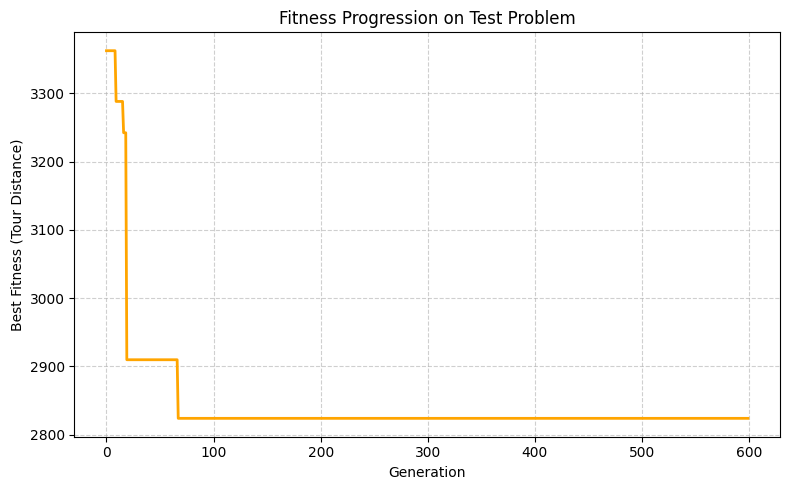

In [56]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
problem = np.load(f"problems/test_problem.npy")
fitness_progress, current_population, _ = solve_TSP(problem=problem, config=Config(len(problem)), verbose=False)
best = current_population[0]
print(f"Best tour distance: {best.fitness:.2f}")
print("Best tour:", ' -> '.join(CITIES[i] for i in best.genotype))

plt.figure(figsize=(8, 5))
plt.plot(fitness_progress, color="orange", lw=2)
plt.title("Fitness Progression on Test Problem")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Tour Distance)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### G problems


 g-10 → Population size: 30, Offspring size: 12, Max generations: 5250, No improvement limit: 432
Run 1/2: Best = 1497.66
Run 2/2: Best = 1497.66

 g-20 → Population size: 30, Offspring size: 12, Max generations: 5500, No improvement limit: 532
Run 1/2: Best = 1755.51
Run 2/2: Best = 1755.51

 g-50 → Population size: 30, Offspring size: 12, Max generations: 6250, No improvement limit: 664
Run 1/2: Best = 2899.32
Run 2/2: Best = 2774.95

 g-100 → Population size: 50, Offspring size: 20, Max generations: 7500, No improvement limit: 764
Run 1/2: Best = 4194.96
Run 2/2: Best = 4191.91

 g-200 → Population size: 100, Offspring size: 40, Max generations: 10000, No improvement limit: 864
Run 1/2: Best = 5864.15
Run 2/2: Best = 5718.38

 g-500 → Population size: 250, Offspring size: 100, Max generations: 17500, No improvement limit: 996
Run 1/2: Best = 8877.28
Run 2/2: Best = 8847.49

 g-1000 → Population size: 500, Offspring size: 200, Max generations: 30000, No improvement limit: 1096
Run 1

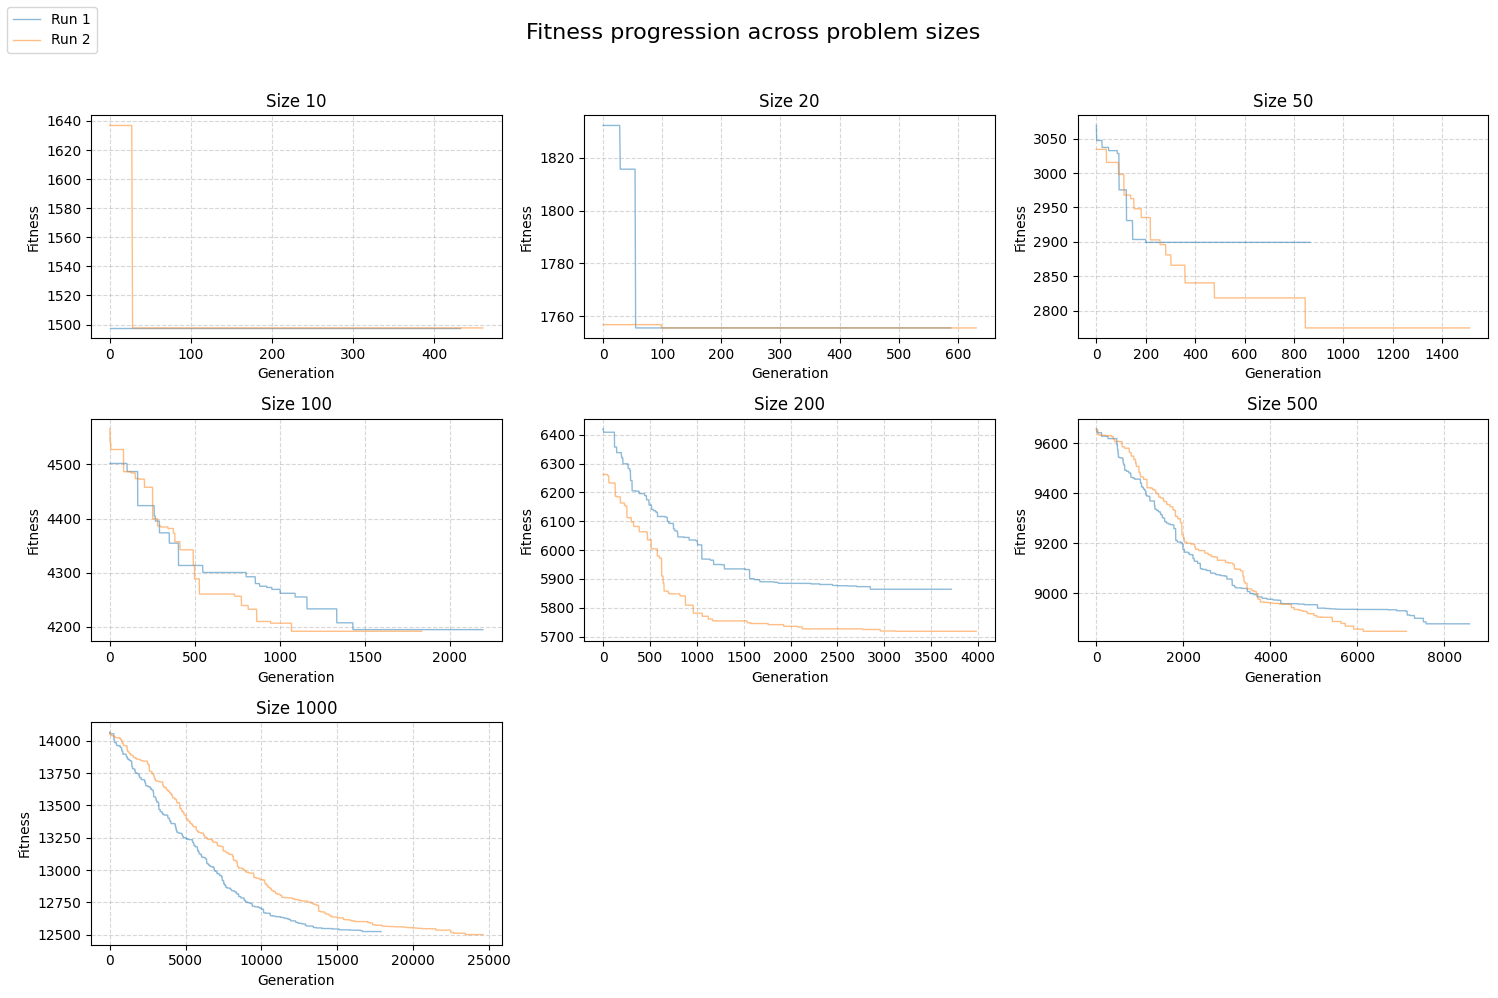

In [57]:
# Set verbose to True to see detailed output
summary = run_experiments('g', 2, verbose=True)

print("\n" + "="*60)
print(f"SUMMARY for type='g' ({len(summary)} problems tested)\n")
print(f"{'Size':>8} | {'Best Distance':>15}")
print("-"*30)
for s in summary:
    print(f"{s['size']:>8} | {min(s['distances']):>15.2f}")
print("-"*30)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, s in enumerate(summary):
    ax = axes[i]
    for run_idx, prog in enumerate(s["progress"]):
        ax.plot(prog, alpha=0.5, lw=1, label=f"Run {run_idx+1}" if i == 0 else None)
    ax.set(title=f"Size {s['size']}", xlabel="Generation", ylabel="Fitness")
    ax.grid(True, ls='--', alpha=0.5)

for ax in axes[len(summary):]:
    fig.delaxes(ax)

fig.suptitle("Fitness progression across problem sizes", fontsize=16)
fig.legend(loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### R1 Problems


 r1-10 → Population size: 30, Offspring size: 12, Max generations: 5250, No improvement limit: 432
Run 1/2: Best = 184.27
Run 2/2: Best = 184.27

 r1-20 → Population size: 30, Offspring size: 12, Max generations: 5500, No improvement limit: 532
Run 1/2: Best = 343.62
Run 2/2: Best = 343.62

 r1-50 → Population size: 30, Offspring size: 12, Max generations: 6250, No improvement limit: 664
Run 1/2: Best = 557.46
Run 2/2: Best = 574.85

 r1-100 → Population size: 50, Offspring size: 20, Max generations: 7500, No improvement limit: 764
Run 1/2: Best = 778.59
Run 2/2: Best = 764.34

 r1-200 → Population size: 100, Offspring size: 40, Max generations: 10000, No improvement limit: 864
Run 1/2: Best = 1096.22
Run 2/2: Best = 1096.92

 r1-500 → Population size: 250, Offspring size: 100, Max generations: 17500, No improvement limit: 996
Run 1/2: Best = 1708.94
Run 2/2: Best = 1663.21

 r1-1000 → Population size: 500, Offspring size: 200, Max generations: 30000, No improvement limit: 1096
Run 1/

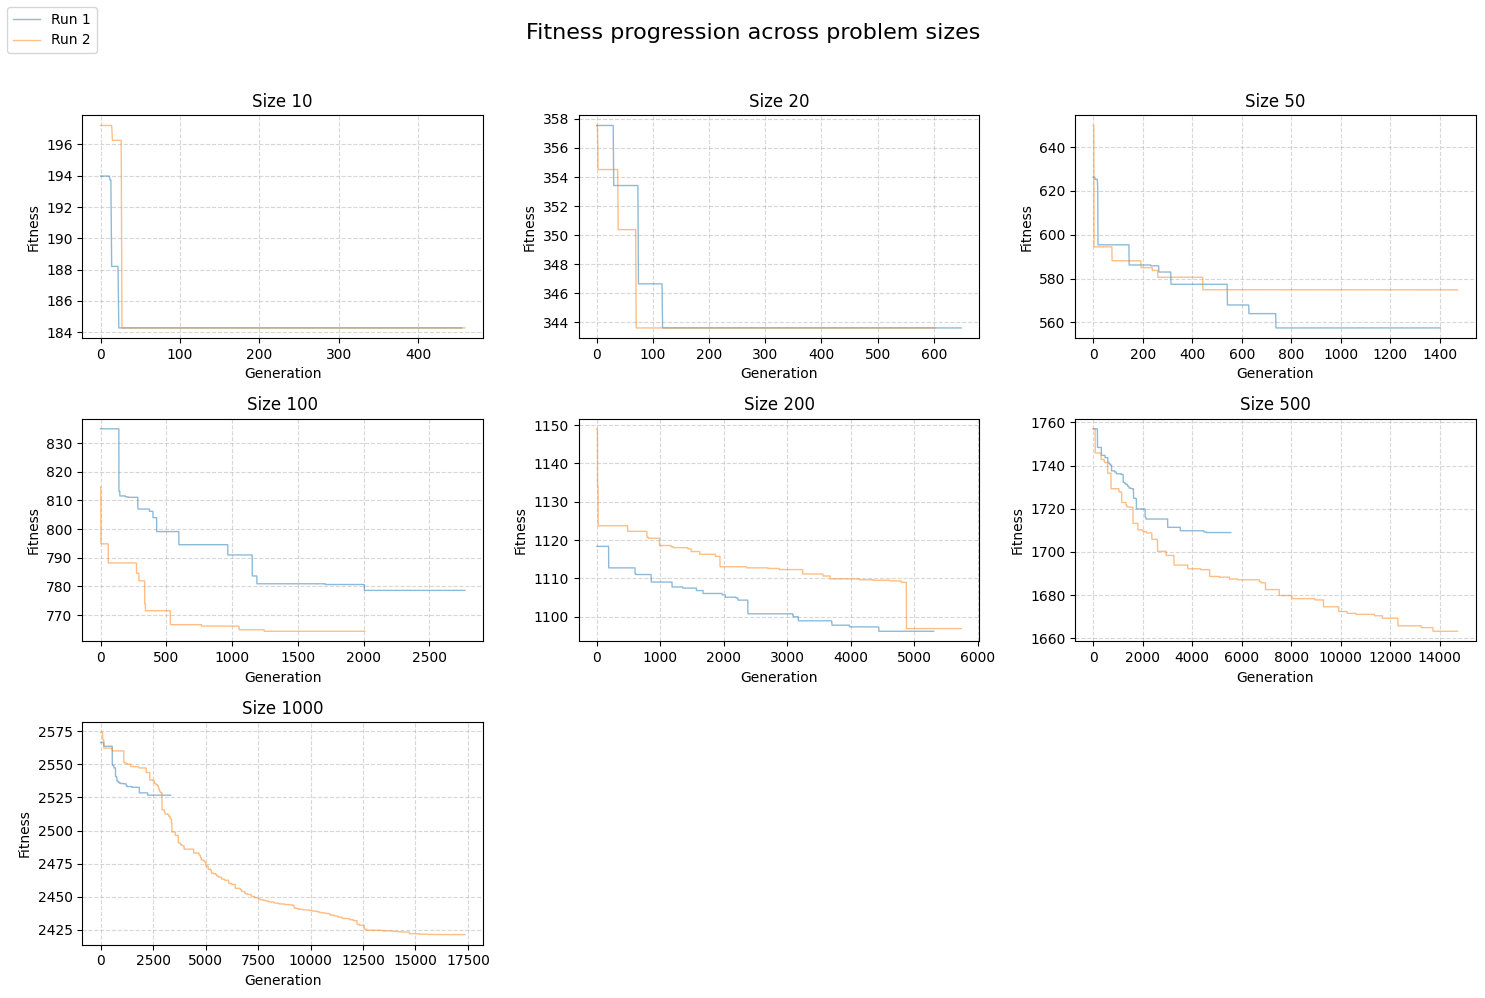

In [58]:
# Set verbose to True to see detailed output
summary = run_experiments('r1', 2, verbose=True)

print("\n" + "="*60)
print(f"SUMMARY for type='r1' ({len(summary)} problems tested)\n")
print(f"{'Size':>8} | {'Best Distance':>15}")
print("-"*30)
for s in summary:
    print(f"{s['size']:>8} | {min(s['distances']):>15.2f}")
print("-"*30)


fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, s in enumerate(summary):
    ax = axes[i]
    for run_idx, prog in enumerate(s["progress"]):
        ax.plot(prog, alpha=0.5, lw=1, label=f"Run {run_idx+1}" if i == 0 else None)
    ax.set(title=f"Size {s['size']}", xlabel="Generation", ylabel="Fitness")
    ax.grid(True, ls='--', alpha=0.5)

for ax in axes[len(summary):]:
    fig.delaxes(ax)

fig.suptitle("Fitness progression across problem sizes", fontsize=16)
fig.legend(loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### R2 Problems


 r2-10 → Population size: 30, Offspring size: 12, Max generations: 5250, No improvement limit: 432
Run 1/2: Best = -411.70
Run 2/2: Best = -411.70

 r2-20 → Population size: 30, Offspring size: 12, Max generations: 5500, No improvement limit: 532
Run 1/2: Best = -808.04
Run 2/2: Best = -808.04

 r2-50 → Population size: 30, Offspring size: 12, Max generations: 6250, No improvement limit: 664
Run 1/2: Best = -2237.00
Run 2/2: Best = -2251.43

 r2-100 → Population size: 50, Offspring size: 20, Max generations: 7500, No improvement limit: 764
Run 1/2: Best = -4722.48
Run 2/2: Best = -4678.06

 r2-200 → Population size: 100, Offspring size: 40, Max generations: 10000, No improvement limit: 864
Run 1/2: Best = -9584.80
Run 2/2: Best = -9608.82

 r2-500 → Population size: 250, Offspring size: 100, Max generations: 17500, No improvement limit: 996
Run 1/2: Best = -24583.54
Run 2/2: Best = -24583.54

 r2-1000 → Population size: 500, Offspring size: 200, Max generations: 30000, No improvement 

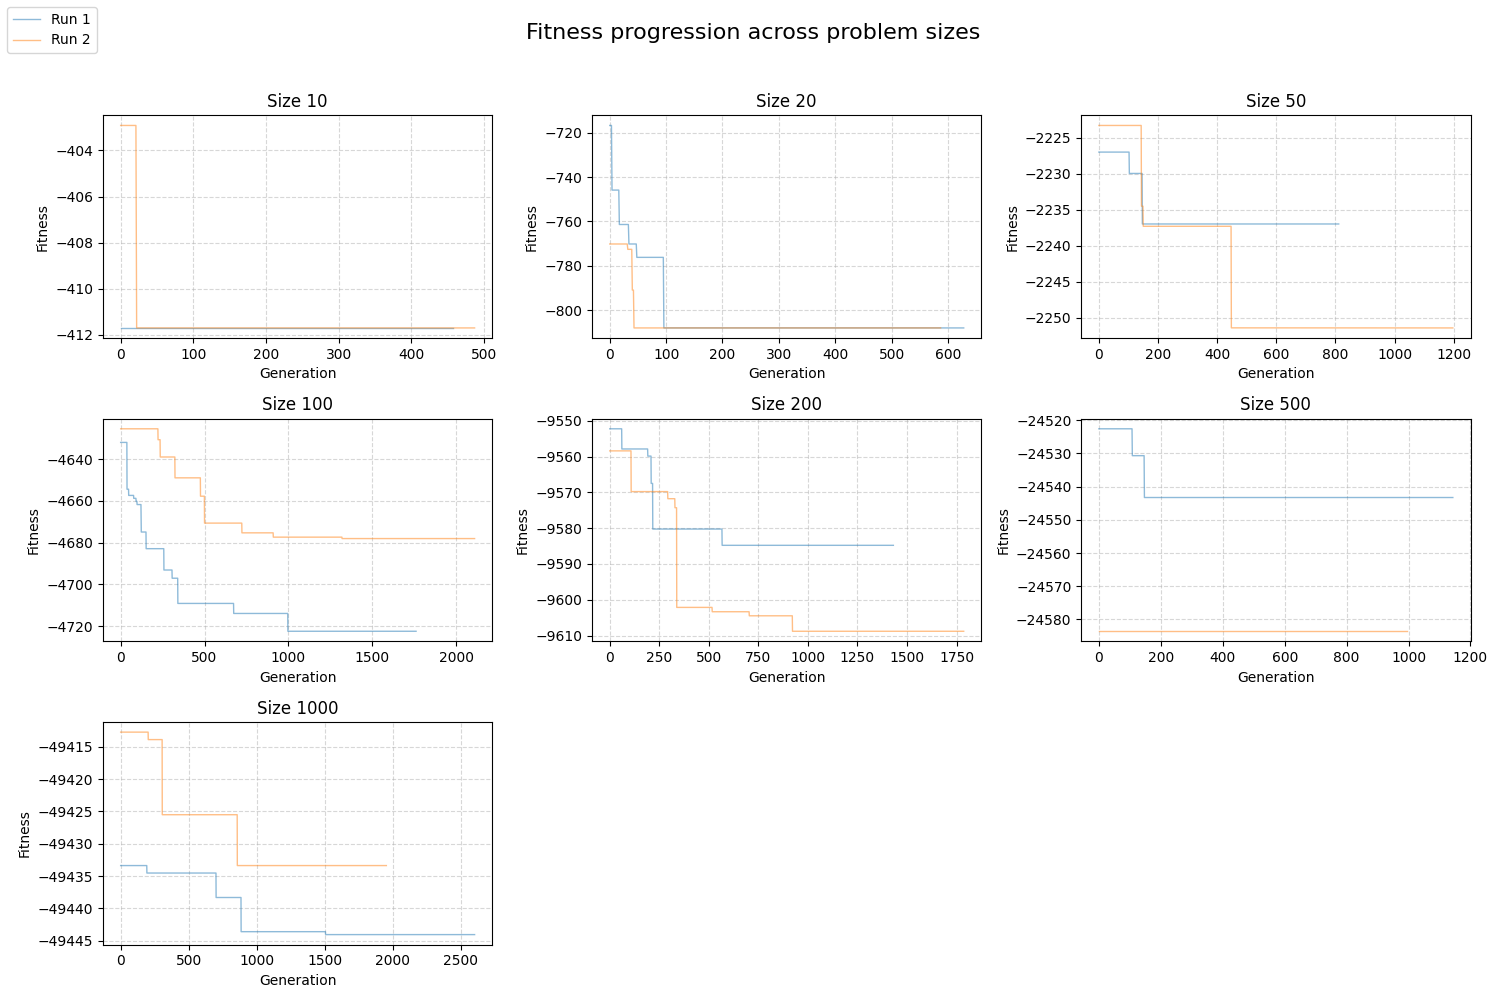

In [61]:
# Set verbose to True to see detailed output
summary = run_experiments('r2', 2, verbose=True)

print("\n" + "="*60)
print(f"SUMMARY for type='r2' ({len(summary)} problems tested)\n")
print(f"{'Size':>8} | {'Best Distance':>15}")
print("-"*30)
for s in summary:
    print(f"{s['size']:>8} | {min(s['distances']):>15.2f}")
print("-"*30)


fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, s in enumerate(summary):
    ax = axes[i]
    for run_idx, prog in enumerate(s["progress"]):
        ax.plot(prog, alpha=0.5, lw=1, label=f"Run {run_idx+1}" if i == 0 else None)
    ax.set(title=f"Size {s['size']}", xlabel="Generation", ylabel="Fitness")
    ax.grid(True, ls='--', alpha=0.5)

for ax in axes[len(summary):]:
    fig.delaxes(ax)

fig.suptitle("Fitness progression across problem sizes", fontsize=16)
fig.legend(loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()